# MNIST VAE

In [154]:
%matplotlib inline

import time
import datetime

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torchvision
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torch.autograd import Variable

DATA_PATH = './data'

In [155]:
# transform the images
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
    ])

# get the dataset
train = MNIST(DATA_PATH, download=True, train=True, transform=transform)
test = MNIST(DATA_PATH, download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

In [156]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [157]:
images[0].numpy().max()

1.0

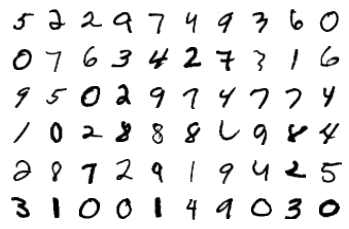

In [158]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [159]:
images[index].numpy().squeeze().shape

(28, 28)

# Network Part

Reference 
* PyTorch Example: [link](https://github.com/pytorch/examples/blob/master/vae/main.py)
* []

In [160]:
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        
        # define the encoder part
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim * 2)
            # multiply z_dim by 2 and use half for mu and half for logvar
        )
        
        # define the decoder
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, x):
        h = self.encoder(x.view(-1, 784))
        # torch.chuck splits the tensor into two chucks
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [161]:
vae = VAE()
print(vae)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=400, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [162]:
# typical Adam
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# loss function
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    return BCE + KLD, BCE, KLD

In [163]:
def flatten(x):
    return x.view(x.size(0), -1)

In [164]:
epochs = 200
times = np.empty(epochs)
losses = {
    'total': [],
    'bce': [],
    'kld': []
}

for e in range(epochs):
    
    total_loss = 0
    total_bce = 0
    total_kld = 0
    times[e] = time.time()
    
    for images, _ in train_loader:
        #images = flatten(images)
        recon_images, mu, logvar = vae(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_bce += bce.item()
        total_kld += kld.item()
    
    # get teh time per epoch
    times[e] = time.time() - times[e]
    # calculate the average losses 
    losses['total'].append(total_loss/len(train_loader))
    losses['bce'].append(total_bce/len(train_loader))
    losses['kld'].append(total_kld/len(train_loader))
    if (e + 1) % 10 == 0:
        print("Epoch {} - time: {:.2f} - Training loss: {}".format(e + 1, times[e], total_loss/len(train_loader)))
    
total_time = times.sum()
mean_time = times.mean()
human_readable_time = datetime.datetime.fromtimestamp(total_time + 6*3600).strftime('%H:%M:%S')
print(f"Ran {epochs} in {human_readable_time} with mean time of {mean_time:0.2f} per epoch")

Epoch 10 - time: 9.14 - Training loss: 13578.037088552772
Epoch 20 - time: 9.20 - Training loss: 13309.727091384595
Epoch 30 - time: 9.24 - Training loss: 13182.815277685235
Epoch 40 - time: 9.38 - Training loss: 13104.377094716152
Epoch 50 - time: 10.11 - Training loss: 13041.371599730144
Epoch 60 - time: 11.45 - Training loss: 13000.139494353012
Epoch 70 - time: 12.33 - Training loss: 12963.222473014392
Epoch 80 - time: 14.29 - Training loss: 12934.05672183169
Epoch 90 - time: 15.33 - Training loss: 12908.667679321028
Epoch 100 - time: 12.70 - Training loss: 12882.31180453758
Epoch 110 - time: 12.83 - Training loss: 12865.35716992604
Epoch 120 - time: 12.78 - Training loss: 12842.45116354611
Epoch 130 - time: 12.72 - Training loss: 12830.116560750932
Epoch 140 - time: 12.73 - Training loss: 12822.505655317163
Epoch 150 - time: 12.79 - Training loss: 12805.431253331557
Epoch 160 - time: 12.69 - Training loss: 12793.050125349813
Epoch 170 - time: 12.35 - Training loss: 12781.9358446328

In [165]:
len(train_loader)

469

In [166]:
sample = Variable(torch.randn(128, 20))
recon_x = vae.decoder(sample)

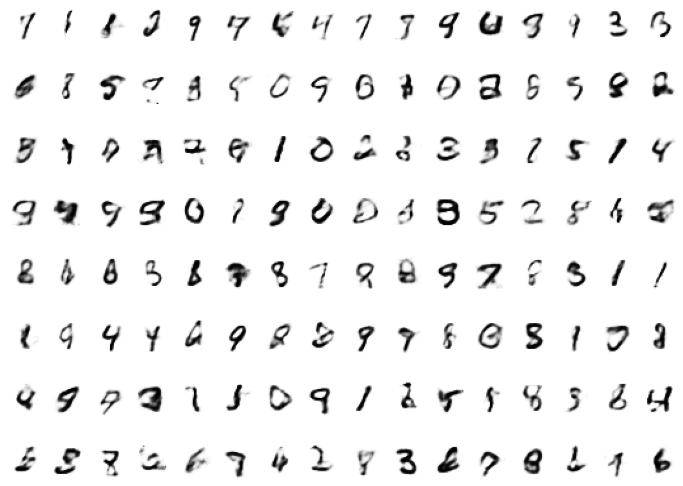

In [167]:
figure = plt.figure(figsize=(12,9));
num_of_images = 128
for index in range(1, num_of_images + 1):
    plt.subplot(8, 16, index);
    plt.axis('off');
    image = recon_x[index - 1].detach().numpy().squeeze().reshape(28,28)
    plt.imshow(image, cmap='gray_r');